# TA Review 9

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Younghun Lee
* hun@uchicago.edu

## 1. Forecasts

Linear Factor Models (LFM's) describe how risk premia vary across assets.

$$
\mathbb{E}\left[\tilde{r}^i\right]
$$

In lecture 7, we analyzed Risk Premia varies over time


### Lagged Regression

$$
r_t=\alpha+\boldsymbol{\beta}^{\prime} \boldsymbol{X}_{t-1}+\epsilon_t \\

\mathbb{E}\left[\tilde{r}_{t+1} \mid x_t\right]=\alpha+\beta x_t
$$

#### Active Investing

Set the scale of the investment in SPY equal to 100 times the forecasted value:
$$
w_t=100 \hat{r}_{t+1}^{\mathrm{SPY}}
$$

Calculate the return on this strategy:
$$
r_{t+1}^{\mathrm{x}}=w_t r_{t+1}^{\mathrm{SPY}}
$$

#### Out-of-Sample Forecasting
- Uses Beta computed up to the current time period to generate returns in future
- Computing OOS R squared
$$
\mathcal{R}_{O O S}^2 \equiv 1-\frac{\sum_{i=61}^T\left(e_i^x\right)^2}{\sum_{i=61}^T\left(e_i^0\right)^2}
$$

where null forcast

$$
\begin{aligned}
\bar{r}_{t+1}^{S P Y} & =\frac{1}{t} \sum_{i=1}^t r_i^{S P Y} \\
e_{t+1}^0 & =r_{t+1}^{S P Y}-\bar{r}_{t+1}^{S P Y}
\end{aligned}
$$

- Looped over an expanding window size




### Dividend Yield

$$
\mathbb{E}_t\left[R_{t, t+k}\right]=\mathrm{DP}_t \mathbb{E}_t\left[\frac{D_{t+k}}{D_t}\right]+\mathbb{E}_t\left[\frac{P_{t+k}}{P_t}\right]
$$

#### Classic View

An increase in the dividend-yield is offset by a decrease in expected dividend growth, because $\theta_r$ is constant and $\theta_p$ is a random noise.

$$
\theta_r=\mathrm{DP}_t \mathbb{E}_t\left[\frac{D_{t+k}}{D_t}\right]+\theta_p
$$

However, we found that it has predictability in longer horizon!

#### Modern View

Expected returns increase one-for-one with the dividend-yield.

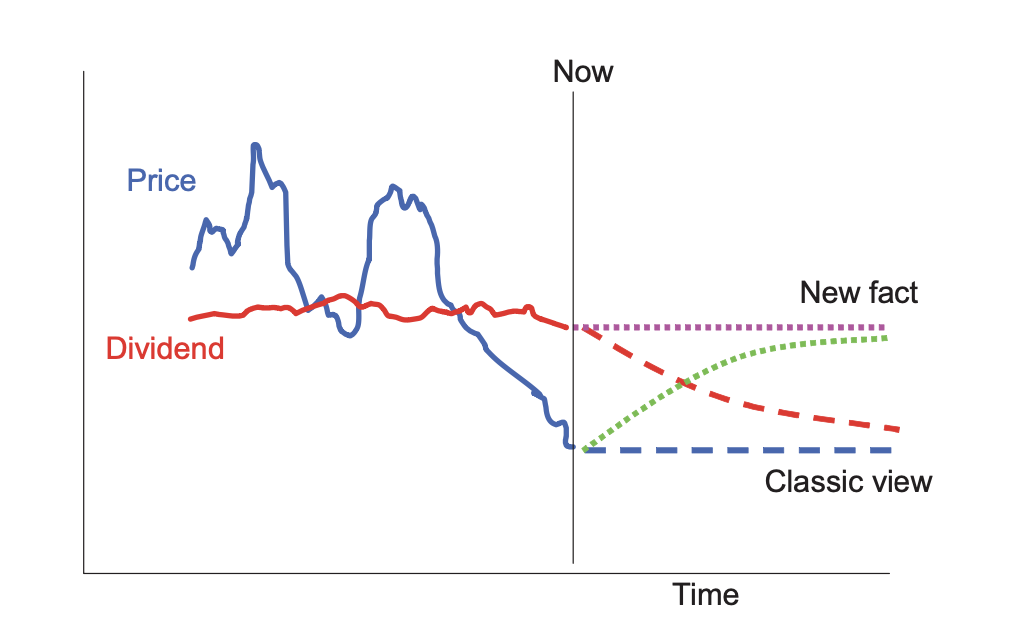

## 2. FX Carry Trade


###  Covered Interest Parity (CIP)

Coming from the Law of One Price, we have two ways of moving USD from $t$ to $t+1$.
1. Invest in the USD risk-free rate.
2. Invest in the Foreign risk-free rate.
   1. Buy Foreign currency, invest in the Foreign risk-free rate
   2. simultaneously use a forward contract to lock in the time $t+1$ price of selling the Foreign currency back for USD.

In log-return terms,

$$
f_t^s-\mathbf{s}_t=\mathrm{r}_{t, t+1}^{f, \$}-\mathrm{r}_{t, t+1}^{f, €}
$$

Or in levels,
$$
\frac{F_t^s}{S_t} R_{t, t+1}^{f, €}=R_{t, t+1}^{f, \$}
$$

This holds well in the data

Forward Premium: $f_t^s-\mathbf{s}_t$

### Uncovered Interest Parity (UIP)

Consider two ways of moving USD from $t$ to $t+1$.
1. At time $t$, one could simply invest in the USD risk-free rate.
2. Invest in the Foreign risk-free rate:
   1. At time $t$, one could buy Foreign currency to invest in the Foreign risk-free rate.
   2. Then at time $t+1$ convert the payoff back to dollars.

$$
\mathbb{E}_t\left[\frac{S_{t+1}}{S_t}\right]=\frac{R_{t+1}^{f, \$}}{R_{t+1}^{f, €}}
$$

In log,

$$
\ln \mathbb{E}_t\left[S_{t+1}\right]-\mathbf{s}_t=\mathrm{r}_{t+1}^{f, \$}-\mathrm{r}_{t+1}^{f, €}
$$

- UIP assumes that FX risk is not priced, and generates no risk premium, FX hedging is idiosyncratic
- UIP claims the expected depreciation of the USD will exactly offset any interest rate premium over the Euro.


### Predicting FX

$$
s_{t+1}^i-s_t^i=\alpha^i+\beta^i\left(\mathrm{r}_{t, t+1}^{f, \$}-\mathrm{r}_{t, t+1}^{f, i}\right)+\epsilon_{t+1}^i
$$

Positive Beta:
- If US Interest Rates increase $=>$ Depreciation of USD
- If Foreign Currency Rates increase $=>$ Appreciation of USD (Strengthening of the USD)

Negative Beta:
- If US Interest Rates increase $\Rightarrow>$ Appreciation of USD
- If Foreign Currency Rates increase $=>$ Depreciation of USD


In [ ]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12
        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)



fx_hldg_reg = []
for k,v in fx_spot_map.items():
    factor = risk_free_rates['log_USD1M'] - risk_free_rates[k]
    strat = fx_rates[v].diff()
    reg = regression_based_performance(factor,strat,0)
    beta_currency = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    fx_hldg_reg.append(pd.DataFrame([[alpha,beta_currency,r_squared]],columns=['Alpha','Beta','R-Squared'],index = [k[4:7]]))


fx_hldg_reg_summary = pd.concat(fx_hldg_reg)
fx_hldg_reg_summary = fx_hldg_reg_summary.T
fx_hldg_reg_summary

,GBP,EUR,CHF,JPY
Alpha,-0.007596,0.008868,0.049584,-0.00114
Beta,0.110666,-1.633806,-2.066667,0.10538
R-Squared,0.000020,0.004398,0.006156,0.00004


## 3. Hedge Fund

#### Active Management

Performance
- Carhart (1997):  Fund with good return faces close to 50/50 chance of excess returns in next period.
- CLT: estimating the confidence interval might include 0, such that the point estimate (mean return) is not statistically significant.
- Statistical Bias:
  - Survivor bias: Data often only available for surviving funds.
  - Backfill bias: At time $t$, we look back at full history of any fund still surviving.
  - Incubator bias: Funds will be incubating for a time before they are launched. Successful incubations launch and report their incubated history.

Measuring Risks
- Stale Price: prices are not updated and returns are smoothed, bias market beta down
- Tail Risk: hedge funds often have a event driven strategy or selling put 


#### Hedge Fund

Why hedge fund?
- enhance returns
- add diversification: 
- get into alternative investments


### LTCM Case:

LTCM has low beta: well hedged

$$
\tilde{r}_t^i=\alpha+\beta_0 \tilde{r}_t^m+\beta_1\left(\tilde{r}_t^m\right)^2+\epsilon_t
$$

In a down market,
- $\beta_1>0$ is like buying put options
- $\beta_1<0$ is like selling put options.

Analogy: $\beta_0$ works as delta of option while $\beta_1$ works as gamma of option.

LTCM Case:
- Negative beta on SPY squared
- LTCM's market exposure behaves as if it is shorting the market options.
- Big market movement would lead underperfromace of LTCM since SPY_Squared is negative.

In [ ]:
df['SPY_Squared'] = df['SPY']**2
df['SPY_Put'] = np.maximum(-0.03 - df['SPY'], 0)
df['SPY_Call'] = np.maximum(df['SPY'] - 0.03, 0)

ta.calc_iterative_regression(df[['LTCM Net', 'LTCM Gross']], df[['SPY', 'SPY_Squared']], one_to_many=True).T

,LTCM Net,LTCM Gross
Alpha,0.155042,0.242387
R-Squared,0.024321,0.028458
SPY Beta,0.166878,0.219805
SPY_Squared Beta,-1.926746,-2.586773
Information Ratio,1.404397,1.805091
Tracking Error,0.110398,0.134280


Nonlinear regression

$$\tilde{r}_t^{\mathrm{LTCM}}=\alpha+\beta \tilde{r}_t^m+\beta_u \max \left(\tilde{r}_t^m-k_1, 0\right)+\beta_d \max \left(k_2-\tilde{r}_t^m, 0\right)+\epsilon_t$$

Here, $\beta_u$ and $\beta_d$ are the betas on the call and put options.
- long puts and short calls
- Long donwside vol and short upside vol

In [ ]:
ta.calc_iterative_regression(df[['LTCM Net', 'LTCM Gross']], df[['SPY', 'SPY_Put', 'SPY_Call']], one_to_many=True).T

,LTCM Net,LTCM Gross
Alpha,0.101231,0.173802
R-Squared,0.055486,0.063774
SPY Beta,0.466610,0.608536
SPY_Put Beta,1.289575,1.632452
SPY_Call Beta,-0.782140,-1.038350
Information Ratio,0.931974,1.318510
Tracking Error,0.108620,0.131817


### About Midterm 2

- Confusion between Strategy and Factor
- Factor premium and regression
- Statistical Property